**타이타닉 우주선이 우주를 비행하다가 침몰 ... 승객이 튀어져 나가버렷는데 찾으러 가야하는 문제임.**

데이터 필드
- **PassengerID**: gggg_pp 승객 탑승아이디 출발 그룹으루 분류
- **HomePlanet**: 출발 지 행성 
- **CroySleep**: 냉동상태로 이동 여부  (????? 수면마취급인가? 뭐지???)
- **Cabin**: 승객이 객실 위치 Deck(아직 뭘 의미하는지 모름)/Num/Side(Side P or S 좌현 우현)\
- **Destination**: 목적지 승객이 내릴 장소
- **Age**
- **VIP**
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: 부가서비스 추가금액(우주선 좋은데?)
- **Name**: 이게 아무런 상관관계가 없어보이지만.. 낚시당할수도 있어 분석해야해
- **Transported**: 예측필드 승객이 튕겨나가 버렸는지 여부

In [ ]:
# 우주타이타닉 문제
import pandas as pd
import numpy as np
train_df = pd.read_csv('data/train.csv')



test_y = pd.read_csv('data/test.csv')
# test_y['VIP'] = test_y['VIP'].astype(int)
tmp_train_df = train_df.drop(columns=['Transported'])


train_df[["Pass_gggg", 'Pass_pp']] = train_df['PassengerId'].str.split('_', expand=True).astype(int)
test_y[["Pass_gggg", 'Pass_pp']] = test_y['PassengerId'].str.split('_', expand=True).astype(int)
train_df["Family_Size"] = train_df.groupby("Pass_gggg")["PassengerId"].transform("count")
test_y["Family_Size"] = test_y.groupby("Pass_gggg")["PassengerId"].transform("count")

train_means = tmp_train_df.select_dtypes(include=['number']).mean()  # 수치형 열 평균
train_modes = tmp_train_df.select_dtypes(exclude=['number']).mode().iloc[0]  # 범주형 열 최빈값
for col in train_means.index:
    test_y[col] = test_y[col].fillna(train_means[col])

for col in train_modes.index:
    test_y[col] = test_y[col].fillna(train_modes[col])
train_df = train_df.dropna()
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

train_df['HomePlanet'] = train_df['HomePlanet'].astype('category')
train_df['HomePlanet'] = train_df['HomePlanet'].cat.codes

train_df['Destination'] = train_df['Destination'].astype('category')
train_df['Destination'] = train_df['Destination'].cat.codes

train_df['Side'] = train_df['Side'].astype('category')
train_df['Side'] = train_df['Side'].cat.codes

train_df['Deck'] = train_df['Deck'].astype('category')
train_df['Deck'] = train_df['Deck'].cat.codes

train_df['SideDeck'] = train_df['Deck'] + train_df['Side']
train_df['SideDeck'] = train_df['SideDeck'].astype('category')
train_df['SideDeck'] = train_df['SideDeck'].cat.codes

train_df['VIP'] = train_df['VIP'].astype(int)
train_df['Transported'] = train_df['Transported'].astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(int)

train_df['Cabin_Num'] = pd.to_numeric(train_df['Cabin'].str.split('/').str[1], errors='coerce')
train_df['Cabin_Num_bin'] = pd.qcut(train_df['Cabin_Num'], q=5, duplicates='drop')


luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_df['Total_Spend'] = train_df[luxury_cols].sum(axis=1)
train_df['Spend_Ratio'] = train_df['Total_Spend'] / (train_df['Age'] + 1)  # 0 나누기 방지


test_y['Total_Spend'] = test_y[luxury_cols].sum(axis=1)
test_y['Spend_Ratio'] = test_y['Total_Spend'] / (test_y['Age'] + 1)

test_y['Cabin_Num'] = pd.to_numeric(test_y['Cabin'].str.split('/').str[1], errors='coerce')
test_y['Cabin_Num_bin'] = pd.qcut(test_y['Cabin_Num'], q=5, duplicates='drop')

test_y['Deck'] = test_y['Cabin'].str.split('/').str[0]
test_y['Side'] = test_y['Cabin'].str.split('/').str[2]

test_y['HomePlanet'] = test_y['HomePlanet'].astype('category')
test_y['HomePlanet'] = test_y['HomePlanet'].cat.codes

test_y['Destination'] = test_y['Destination'].astype('category')
test_y['Destination'] = test_y['Destination'].cat.codes

test_y['Side'] = test_y['Side'].astype('category')
test_y['Side'] = test_y['Side'].cat.codes

test_y['Deck'] = test_y['Deck'].astype('category')
test_y['Deck'] = test_y['Deck'].cat.codes

test_y['SideDeck'] = test_y['Deck'] + test_y['Side']
test_y['SideDeck'] = test_y['SideDeck'].astype('category')
test_y['SideDeck'] = test_y['SideDeck'].cat.codes

test_y['VIP'] = test_y['VIP'].astype(int)
test_y['CryoSleep'] = test_y['CryoSleep'].astype(int)

# 로그 변환 적용
train_df['Total_Spend'] = train_df['Total_Spend'].apply(lambda x: np.log1p(x))
train_df['Spend_Ratio'] = train_df['Spend_Ratio'].apply(lambda x: np.log1p(x))

test_y['Total_Spend'] = test_y['Total_Spend'].apply(lambda x: np.log1p(x))
test_y['Spend_Ratio'] = test_y['Spend_Ratio'].apply(lambda x: np.log1p(x))


for col in luxury_cols:
    train_df[col + "_Ratio"] = train_df[col] / (train_df["Total_Spend"] + 1)
    test_y[col + "_Ratio"] = test_y[col] / (test_y["Total_Spend"] + 1)


train_df["Luxury_Spender"] = (train_df["Total_Spend"] > train_df["Total_Spend"].median()).astype(int)
test_y["Luxury_Spender"] = (test_y["Total_Spend"] > test_y["Total_Spend"].median()).astype(int)

# 혼자 온 손님 분류
train_df["Is_Alone"] = (train_df["Family_Size"] == 1).astype(int)
test_y["Is_Alone"] = (test_y["Family_Size"] == 1).astype(int)

# 나이 군집화
train_df["Age_Group"] = pd.cut(train_df["Age"], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])
test_y["Age_Group"] = pd.cut(test_y["Age"], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])

# 손님 비율
train_df["Spend_Per_Person"] = train_df["Total_Spend"] / (train_df["Family_Size"] + 1)
test_y["Spend_Per_Person"] = test_y["Total_Spend"] / (test_y["Family_Size"] + 1)

# 극단 값 제거
train_df["Total_Spend"] = np.clip(train_df["Total_Spend"], 0, train_df["Total_Spend"].quantile(0.99))
test_y["Total_Spend"] = np.clip(test_y["Total_Spend"], 0, test_y["Total_Spend"].quantile(0.99))

/tmp/ipykernel_80259/348675095.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y[col] = test_y[col].fillna(train_modes[col])


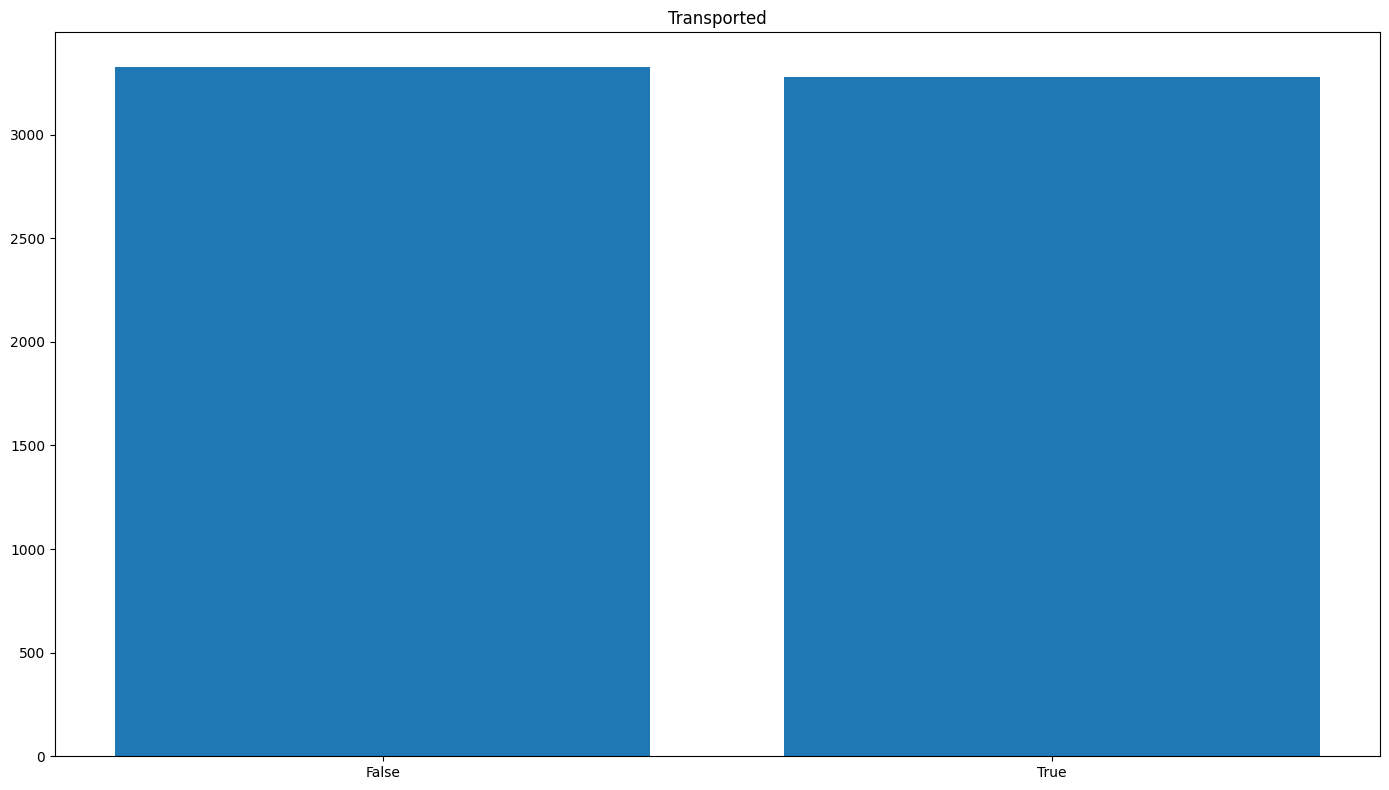

In [20]:
# 데이터 분석!
import matplotlib.pyplot as plt

transport_df = train_df[train_df['Transported'] == False]
# 생존자 비율~
fig, ax = plt.subplots(1, 1)
ax.set_title("Transported")
ax.bar(['False', 'True'], train_df['Transported'].value_counts())

plt.tight_layout()
plt.show()


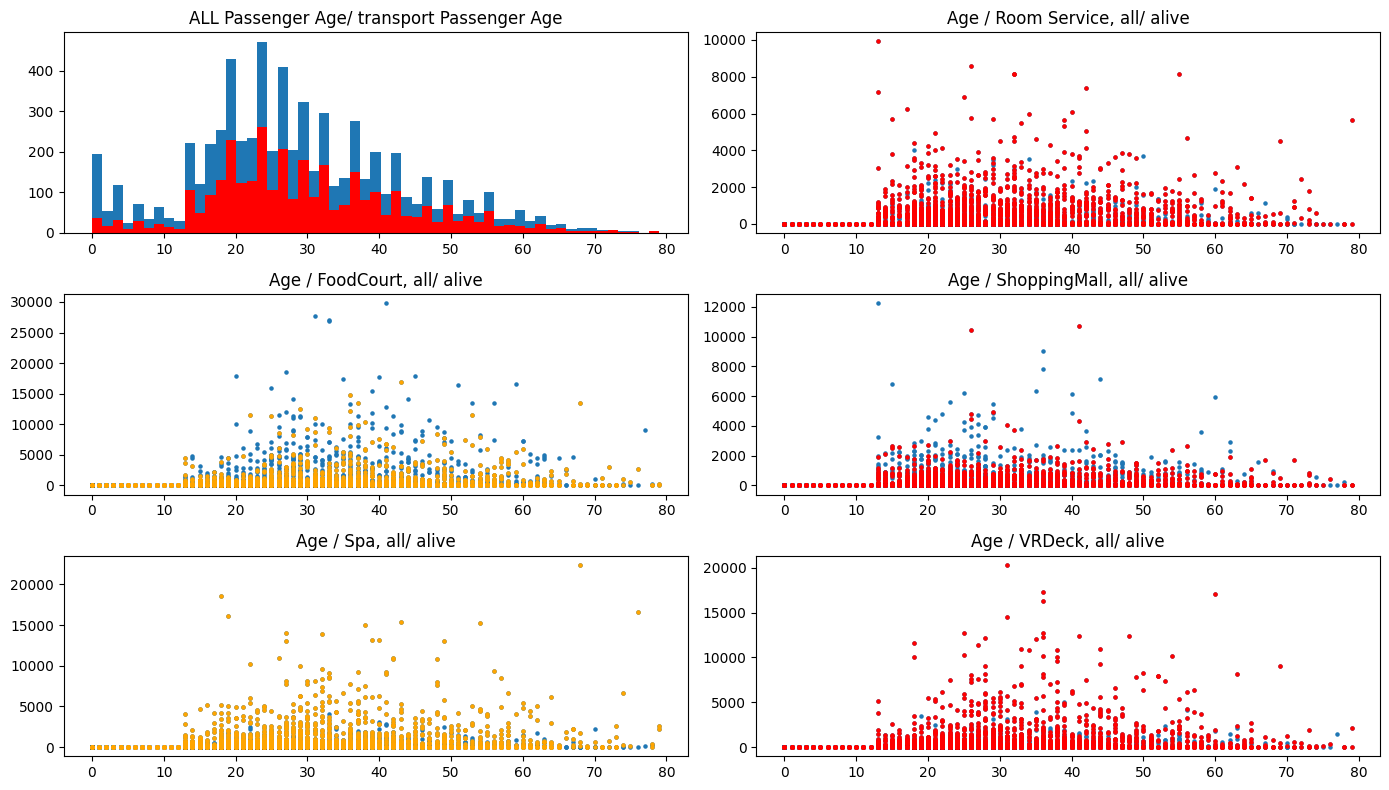

In [21]:
# 나이 상관관계 분석
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['Age'], bins=55, label='ALL Passenger Age')
ax[0][0].set_title("ALL Passenger Age/ transport Passenger Age")
ax[0][0].hist(transport_df['Age'], bins=55, color='red', label='transport Passenger Age')

ax[0][1].scatter(train_df['Age'], train_df['RoomService'], s=5)
ax[0][1].scatter(transport_df['Age'], transport_df['RoomService'], color='red', s=5)
ax[0][1].set_title("Age / Room Service, all/ alive")

ax[1][0].scatter(train_df['Age'], train_df['FoodCourt'], s=5)
ax[1][0].scatter(transport_df['Age'], transport_df['FoodCourt'], color='orange', s=5)
ax[1][0].set_title("Age / FoodCourt, all/ alive")

ax[1][1].scatter(train_df['Age'], train_df['ShoppingMall'], s=5)
ax[1][1].scatter(transport_df['Age'], transport_df['ShoppingMall'], s=5, color='red')
ax[1][1].set_title("Age / ShoppingMall, all/ alive")

ax[2][0].scatter(train_df['Age'], train_df['Spa'], s=5)
ax[2][0].scatter(transport_df['Age'], transport_df['Spa'], s=5, color='orange')
ax[2][0].set_title("Age / Spa, all/ alive")

ax[2][1].scatter(train_df['Age'], train_df['VRDeck'], s=5)
ax[2][1].scatter(transport_df['Age'], transport_df['VRDeck'], s=5, color='red')
ax[2][1].set_title("Age / VRDeck, all/ alive")

plt.tight_layout()
plt.show()

162 102


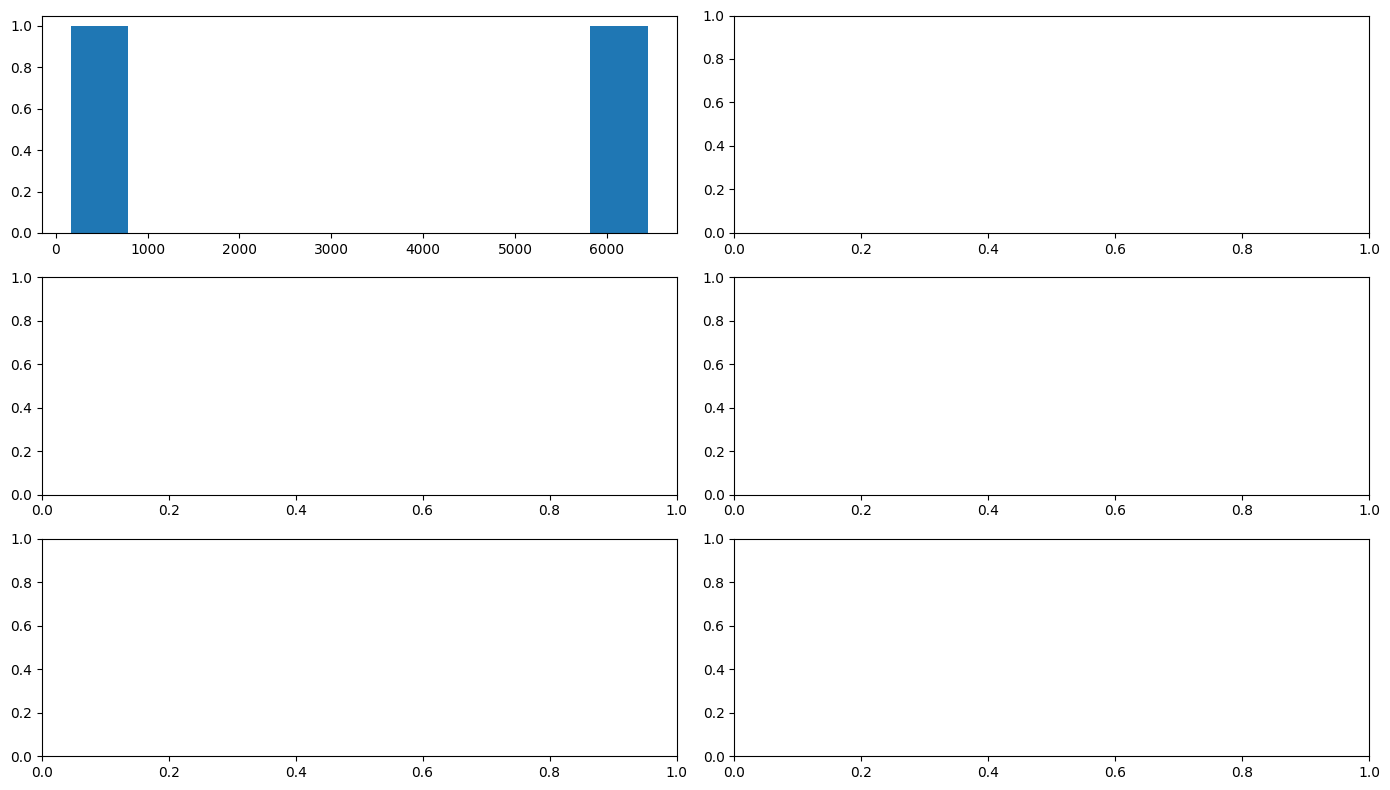

In [22]:
# VIP 상관관계 분석
print(len(train_df[train_df['VIP']==True]), len(transport_df[transport_df['VIP'] == True]))
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['VIP'].value_counts())


plt.tight_layout()
plt.show()

In [23]:
df = train_df.select_dtypes(include=['number'])
df['Transported'] = train_df['Transported'].astype(int)
df['CryoSleep'] = train_df['CryoSleep'].astype(int)

print('------------------------------------------')
print(df.corr()['Transported'].sort_values(key=lambda x: x.abs()))

------------------------------------------
ShoppingMall_Ratio    0.010128
ShoppingMall          0.011602
Pass_gggg             0.023216
VIP                  -0.042260
Cabin_Num            -0.046766
FoodCourt             0.055025
FoodCourt_Ratio       0.058026
Pass_pp               0.075980
SideDeck             -0.080749
Age                  -0.082553
Family_Size           0.086274
Side                  0.106186
HomePlanet            0.111806
Deck                 -0.112588
Destination          -0.123773
VRDeck               -0.207950
Spa                  -0.219854
VRDeck_Ratio         -0.223897
Spa_Ratio            -0.238257
RoomService          -0.247291
RoomService_Ratio    -0.263098
Spend_Ratio          -0.443847
CryoSleep             0.462803
Total_Spend          -0.463743
Transported           1.000000
Name: Transported, dtype: float64


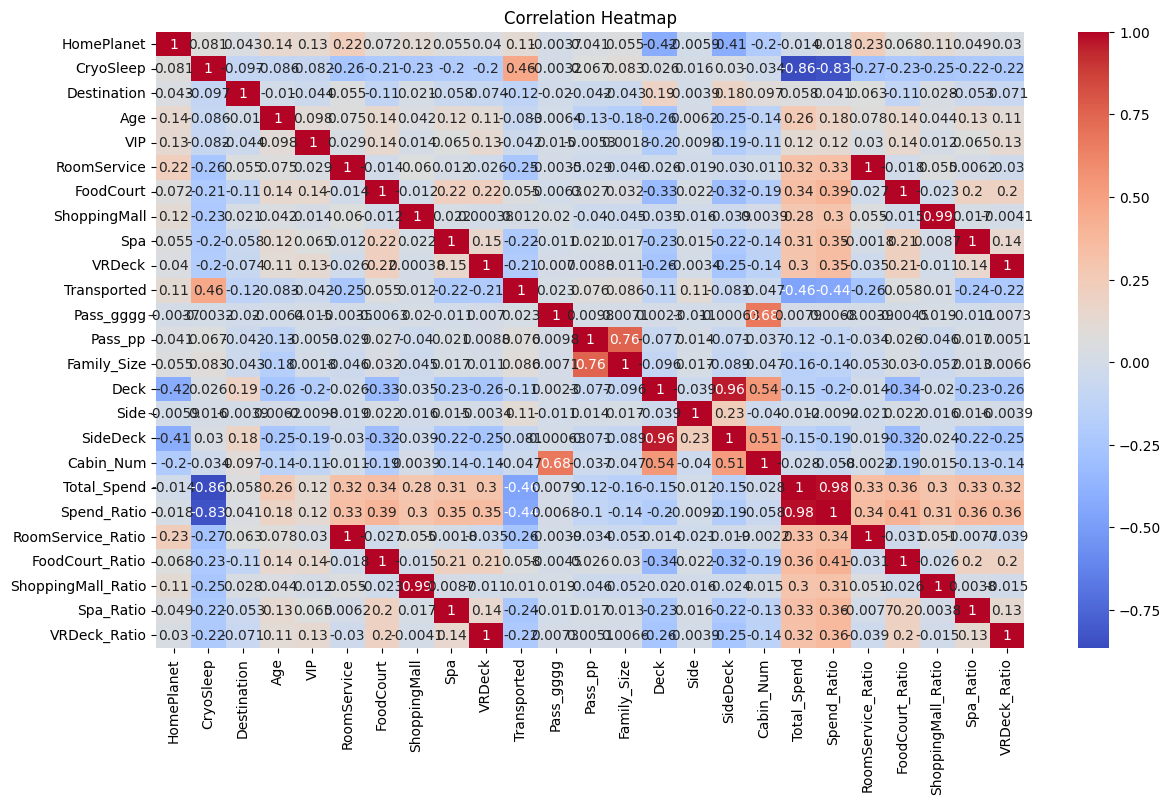

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

corr_matrix = df.corr()
# print(corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.1].index.tolist())
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### 상관 관계 도출.
- ShoppingMall    0.011602
- FoodCourt       0.055025
- Age            -0.082553
- Side            0.106186
- HomePlanet      0.111806
- CabDeckin      -0.112588
- Destination    -0.123773
- VRDeck         -0.207950
- Spa            -0.219854
- RoomService    -0.247291
- CryoSleep       0.462803
- Transported     1.000000

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 결정트리 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"결정트리 분류 정확도: {accuracy_score(y_pred, y_test)}")

결정트리 분류 정확도: 0.7578692493946732


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 랜덤 포레스트 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

랜덤포레스트 정확도: 0.8008474576271186


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb


# 랜덤 포레스트 분류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Xgb Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")


Xgb Boost 분류 정확도: 0.8002421307506054


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


# "cat Boost
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)


X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
y_pred = model.predict(X_test)

print(f"cat Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")

0:	learn: 0.6710362	total: 1.54ms	remaining: 770ms
100:	learn: 0.3736262	total: 158ms	remaining: 625ms
200:	learn: 0.3298470	total: 298ms	remaining: 443ms
300:	learn: 0.2931979	total: 443ms	remaining: 293ms
400:	learn: 0.2652687	total: 583ms	remaining: 144ms
499:	learn: 0.2435132	total: 719ms	remaining: 0us
               Feature  Importance
0           HomePlanet    8.678899
1            CryoSleep    4.540272
2          Destination    3.120486
3                  Age    5.360480
4                  VIP    0.094220
5          RoomService    2.475116
6            FoodCourt    3.791616
7         ShoppingMall    1.718130
8                  Spa    3.907188
9               VRDeck    3.202247
10           Pass_gggg    4.767496
11             Pass_pp    1.035827
12         Family_Size    1.351444
13                Deck    7.827690
14                Side    3.598361
15            SideDeck    4.830057
16           Cabin_Num    8.537094
17         Total_Spend    6.385475
18         Spend_Ratio    

In [29]:
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

class ML_Model:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=1)

        self.desiciontree = DecisionTreeClassifier()
        self.randomforest = RandomForestClassifier()
        self.xgboost = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.cat_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)

    def train(self):    
        self.desiciontree.fit(self.X_train, self.y_train)
        self.randomforest.fit(self.X_train, self.y_train)
        self.xgboost.fit(self.X_train, self.y_train)
        self.cat_model.fit(self.X_train, self.y_train)


        self.dtree_y_pred = self.desiciontree.predict(self.X_test)
        self.randomforest_y_pred = self.randomforest.predict(self.X_test)
        self.xgboost_y_pred = self.xgboost.predict(self.X_test)
        self.catboost_y_pred = self.cat_model.predict(self.X_test)
    
    def evaluate(self):
        
        pred_list = [self.dtree_y_pred, self.randomforest_y_pred,
                     self.xgboost_y_pred, self.catboost_y_pred]
        best_score = 0
        best_idnex = 0
        for index, pred in enumerate(pred_list):

            score = cross_val_score(self.y_test, pred)
            if score > best_score:
                best_idnex = index
                best_score = score
                

            print(f"정확도: {cross_val_score(self.y_test, pred)}")
        print(f'최고 정확도: {best_score}, 최고 모델: {best_idnex}')

In [30]:

X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])
X_reduced = X.drop(columns=low_importance)

ml_model = ML_Model(X_reduced, y)
ml_model.train()
ml_model.evaluate()

0:	learn: 0.6732017	total: 1.31ms	remaining: 656ms
100:	learn: 0.4820526	total: 126ms	remaining: 499ms
200:	learn: 0.4563297	total: 245ms	remaining: 364ms
300:	learn: 0.4291804	total: 363ms	remaining: 240ms
400:	learn: 0.4068910	total: 501ms	remaining: 124ms
499:	learn: 0.3869149	total: 643ms	remaining: 0us


InvalidParameterError: The 'estimator' parameter of cross_val_score must be an object implementing 'fit'. Got 5606    0
8226    0
1288    0
3220    1
4596    0
       ..
1285    0
7287    0
7217    1
573     1
5327    1
Name: Transported, Length: 1652, dtype: int64 instead.

In [ ]:
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
X_reduced = X.drop(columns=low_importance)

# test_y = pd.read_csv('data/test.csv')
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y)

model = ml_model.cat_model
model.fit(X_train, y_train)

y_pred = model.predict(test_y)
print(y_pred)
# print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

         Feature  Importance
0     HomePlanet    8.476847
1      CryoSleep    3.446168
2    Destination    3.836437
3            Age    5.325203
4            VIP    0.111388
5    RoomService    5.512557
6      FoodCourt    6.529846
7   ShoppingMall    4.351638
8            Spa    9.353893
9         VRDeck    7.563586
10     Pass_gggg    5.591469
11       Pass_pp    1.300677
12          Deck    6.965315
13          Side    3.923612
14      SideDeck    5.462782
15     Cabin_Num    8.537729
16   Total_Spend    7.478171
17   Spend_Ratio    6.232681
['CryoSleep', 'Destination', 'VIP', 'ShoppingMall', 'Pass_pp', 'Side']
0:	learn: 0.6710412	total: 3.27ms	remaining: 1.63s
100:	learn: 0.3875132	total: 142ms	remaining: 562ms
200:	learn: 0.3436936	total: 274ms	remaining: 408ms
300:	learn: 0.3105703	total: 405ms	remaining: 268ms
400:	learn: 0.2837424	total: 536ms	remaining: 132ms
499:	learn: 0.2621120	total: 662ms	remaining: 0us
[1 0 1 ... 1 1 1]


In [ ]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({1: 'True', 0: 'False'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

     PassengerId Transported
0        0013_01        True
1        0018_01       False
2        0019_01        True
3        0021_01        True
4        0023_01        True
...          ...         ...
4272     9266_02        True
4273     9269_01        True
4274     9271_01        True
4275     9273_01        True
4276     9277_01        True

[4277 rows x 2 columns]


In [ ]:
from optuna import create_study
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    iterations = trial.suggest_int('iterations', 100, 1000)
    
    model = CatBoostClassifier(
        depth=depth, learning_rate=learning_rate, iterations=iterations, verbose=0
    )
    
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
    return score

study = create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)


/mnt/d/workspace/TIL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-13 12:18:19,664] A new study created in memory with name: no-name-7921b9d6-92d7-4121-8988-175ae3486440
[I 2025-03-13 12:18:41,935] Trial 0 finished with value: 0.7691613766218001 and parameters: {'depth': 10, 'learning_rate': 0.018788179436909448, 'iterations': 409}. Best is trial 0 with value: 0.7691613766218001.
[I 2025-03-13 12:19:32,171] Trial 1 finished with value: 0.7528144794721827 and parameters: {'depth': 10, 'learning_rate': 0.015108726868116037, 'iterations': 981}. Best is trial 0 with value: 0.7691613766218001.
[I 2025-03-13 12:19:52,556] Trial 2 finished with value: 0.7493339868824447 and parameters: {'depth': 10, 'learning_rate': 0.05135310017544848, 'iterations': 373}. Best is trial 0 with value: 0.76916

Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}


In [ ]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# from lightgbm  import LGBMClassifier
import lightgbm
corr_matrix = df.corr()

selected_columns  = corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.1].drop('Transported').index.tolist()

X = train_df.select_dtypes(include=['number'])
y = train_df.Transported

X = X.drop(columns=['Transported'])

cat_model = CatBoostClassifier(iterations=500, learning_rate=0.04, depth=5)
# cat_model = CatBoostClassifier(iterations=149, learning_rate=0.014312306387909162, depth=10)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.04, max_depth=3)
randomforest = RandomForestClassifier(n_estimators=100)
lgbm_model = lightgbm.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
# Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}


# model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model)], voting='soft')

estimators = [('cat', cat_model), ('xgb', xgb_model), ('lgbm', lgbm_model)]
model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
# print(X.columns, test_y.columns)
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print(X_train.columns, X_test.columns)
# model = cat_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
y_pred = model.predict(test_y)

# print(cross_val_score(model, X, y, cv=10, scoring='accuracy'))

0:	learn: 0.6740398	total: 1.85ms	remaining: 924ms
1:	learn: 0.6567492	total: 3.3ms	remaining: 823ms
2:	learn: 0.6421091	total: 4.9ms	remaining: 812ms
3:	learn: 0.6272117	total: 6.4ms	remaining: 794ms
4:	learn: 0.6156190	total: 7.99ms	remaining: 791ms
5:	learn: 0.6056004	total: 9.49ms	remaining: 782ms
6:	learn: 0.5944306	total: 11.1ms	remaining: 783ms
7:	learn: 0.5848494	total: 12.7ms	remaining: 780ms
8:	learn: 0.5754089	total: 14.9ms	remaining: 814ms
9:	learn: 0.5661093	total: 16.3ms	remaining: 798ms
10:	learn: 0.5589904	total: 17.6ms	remaining: 784ms
11:	learn: 0.5519444	total: 18.8ms	remaining: 763ms
12:	learn: 0.5453663	total: 20ms	remaining: 751ms
13:	learn: 0.5396148	total: 21.4ms	remaining: 743ms
14:	learn: 0.5331684	total: 23ms	remaining: 742ms
15:	learn: 0.5270294	total: 24.3ms	remaining: 736ms
16:	learn: 0.5229290	total: 25.5ms	remaining: 725ms
17:	learn: 0.5181093	total: 26.7ms	remaining: 715ms
18:	learn: 0.5144976	total: 27.8ms	remaining: 705ms
19:	learn: 0.5111243	total: 2

In [38]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({0: 'False', 1: 'True'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)


     PassengerId Transported
0        0013_01       False
1        0018_01       False
2        0019_01        True
3        0021_01        True
4        0023_01        True
...          ...         ...
4272     9266_02        True
4273     9269_01        True
4274     9271_01        True
4275     9273_01        True
4276     9277_01        True

[4277 rows x 2 columns]
